In [61]:
import build_master_df
import pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [62]:
df = build_master_df.build_df()
df = df.drop(columns=['state_x','state_y','CountyFIPS'])

reading google mobility...
reading NAICS...
merging NAICS...
reading ACS...
merging ACS...
reading cdc wonderdata...
merging wonderdata...
interpolating wonderdata counties with state...
dropping columns...
reading cdc cases and deaths...
merging cdc cases and deaths...
reading kaggle weather+ data...
merging kaggle weather+ data...
reading interventions...
merging interventions...


In [63]:
def impute_missing(df):
    total_rows = df_numeric.shape[0]
    for col in df.columns: 
        num_missing = df[col].isna().sum()
        if (float(num_missing)/float(total_rows)) < 0.1:
            print(f"Imputing {num_missing:,} values for {col}")
            df.loc[:,col] = df.loc[:,col].fillna(df.loc[:,col].median())
        else:
            print(f"Dropping {col}... too many missing")
            df = df.drop(columns=[col])
    return df

In [64]:
def normalize_vars(df):

    # Scale numeric data
    scaler = StandardScaler()
    dfscale = pd.DataFrame(scaler.fit_transform(df))

    # Fix columns and indices
    df.columns = df.columns
    df.index = df.index

    return df

In [66]:
# Subset columns to keep
keptcols1 = [col for col in df_numeric.columns if col.startswith('Percent')]
keptcols2 = [col for col in df_numeric.columns if col.endswith('_pct')]
keptcols = keptcols1+keptcols2
df_numeric = df.select_dtypes(include=['number'])[keptcols]

# Identify missing values and normalize
df_numeric = impute_missing(df_numeric)
df_numeric = normalize_vars(df_numeric)

Imputing 0 values for PercentAsthma
Imputing 0 values for PercentObese
Imputing 0 values for PercentBingeDrink
Imputing 0 values for PercentCOPD
Imputing 0 values for PercentCoronaryHeartDisease
Imputing 0 values for PercentCurrentSmoker
Imputing 0 values for PercentDepression
Imputing 0 values for PercentDiabetes
Imputing 0 values for PercentDifficultyErrandsAlone
Imputing 0 values for PercentFluShot
Imputing 0 values for PercentHealthCoverage
Imputing 0 values for PercentOtherCancer
Imputing 0 values for PercentSeatbeltUse
Imputing 0 values for PercentSkinCancer
Imputing 0 values for PercentStroke
Imputing 0 values for PercentTooExpensiveToSeeDoctor
Imputing 0 values for pop_u5_pct
Imputing 0 values for pop_5to9_pct
Imputing 0 values for pop_10to14_pct
Imputing 0 values for pop_15to19_pct
Imputing 0 values for pop_20to24_pct
Imputing 0 values for pop_25to29_pct
Imputing 0 values for pop_30to34_pct
Imputing 0 values for pop_35to39_pct
Imputing 0 values for pop_40to44_pct
Imputing 0 va

In [71]:
pca = PCA(n_components=10)
pca.fit(df_numeric)
df_numeric_pca = pca.transform(df_numeric)

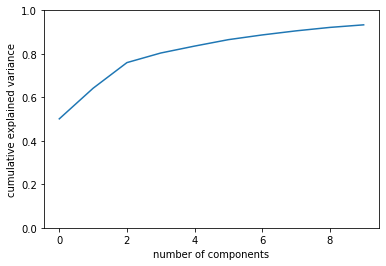

In [72]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim([0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [73]:
PCs = pd.DataFrame(pca.components_, columns=df_numeric.columns)
PCs['explained variance'] = pca.explained_variance_ratio_.round(2)
PCs

,PercentAsthma,PercentObese,PercentBingeDrink,PercentCOPD,PercentCoronaryHeartDisease,PercentCurrentSmoker,PercentDepression,PercentDiabetes,PercentDifficultyErrandsAlone,PercentFluShot,...,has_broadband_pct,has_celldata_only_pct,has_no_internet_pct,workers_pct,households_u18_pct,households_o60_pct,household_owner_occupied_pct,household_rented_pct,food_stamps_pct,explained variance
0,0.002846,0.065590,-0.027139,0.032290,0.015805,0.039948,0.018812,0.035069,0.025953,-0.059997,...,-0.306545,0.064407,0.303095,-0.001626,0.000054,0.000086,0.000128,0.000052,0.001448,0.50
1,0.011308,0.018143,-0.022489,0.027786,0.012285,0.028107,0.019131,0.021878,0.019063,0.025202,...,-0.163985,-0.016707,0.160972,-0.000570,-0.000022,-0.000018,-0.000038,-0.000020,0.000664,0.14
2,-0.001905,0.034419,-0.054310,0.021603,0.009704,0.019153,0.023872,0.034448,0.025762,-0.025063,...,-0.142801,0.035265,0.144551,-0.000836,0.000016,0.000030,0.000030,0.000019,0.000504,0.12
3,-0.069900,-0.007463,-0.060941,-0.059024,-0.031917,-0.131545,-0.147348,0.031571,-0.029082,-0.323218,...,0.050540,0.165328,-0.032945,-0.000608,0.000068,0.000042,0.000036,0.000066,0.000686,0.04
4,0.004696,0.023985,-0.098494,0.030250,0.013453,0.023093,0.032570,0.020899,0.045396,0.621672,...,-0.096408,-0.074145,0.114474,0.000130,-0.000113,-0.000267,-0.000366,-0.000109,0.001215,0.03
5,-0.049905,-0.194873,0.114191,-0.157119,-0.069584,-0.224845,-0.224757,-0.095885,-0.117332,-0.496725,...,-0.150145,-0.199485,0.142569,0.000954,0.000025,0.000060,0.000082,0.000046,-0.000928,0.03
6,0.101564,0.284833,-0.112706,0.227998,0.104661,0.336606,0.299227,0.175799,0.191599,-0.470887,...,0.057039,0.014866,-0.044151,-0.000735,-0.000111,-0.000181,-0.000298,-0.000087,0.001622,0.02
7,-0.058070,-0.006038,0.134503,-0.076622,-0.038455,-0.051290,-0.100722,-0.059552,-0.061166,0.096269,...,0.015178,0.192253,-0.022140,0.001313,0.000006,-0.000014,0.000017,-0.000025,-0.001238,0.02
8,0.047768,-0.203680,-0.078271,0.010846,-0.003368,-0.106083,-0.018221,-0.014239,-0.007601,0.004680,...,0.215732,-0.397442,-0.210518,-0.002742,-0.000080,-0.000074,-0.000227,-0.000013,0.004036,0.02
9,0.000519,0.049643,-0.247618,0.079710,0.040937,0.012368,0.035375,0.117266,0.087273,0.069184,...,0.008796,-0.200278,-0.015082,-0.002734,0.000093,0.000424,0.000447,0.000146,-0.001496,0.01


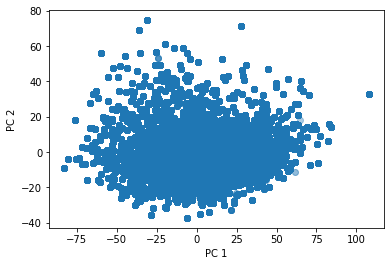

In [74]:
plt.scatter(df_numeric_pca[:, 0], df_numeric_pca[:, 1], alpha=0.2)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()